# Classification of Questions

## Introduction

This notebook is dedicated to a challenging task in the realm of Deep Learning - the classification of questions into two categories: sincere and insincere. Our dataset comprises over 250,000 training questions, each labeled as either honest or dishonest, providing a rich ground for training and testing our models.

### Objective

The primary goal is to implement and train models specifically on this dataset, evaluating their performance in accurately categorizing the questions. This task not only tests the practical application of deep learning models but also emphasizes the importance of precise data preprocessing and model tuning.

### Approach

We will explore the dataset, implement various models, and train them to classify questions effectively. The use of pre-trained embeddings is allowed, although the models themselves should be built and trained from scratch. Special attention will be paid to the preprocessing of text data, ensuring that every decision is data-driven and well-justified.

### Evaluation Metrics

The model's performance will be evaluated using metrics such as accuracy, precision, recall, and F1 score, with a particular focus on the F1 score due to the dataset's imbalance.

### Tools and Technologies

- Programming Language: Python
- Main Libraries: PyTorch, Pandas, NumPy, Matplotlib, scikit-learn

This notebook aims to not only build a robust model for question classification but also to serve as a comprehensive guide through the process of model selection, training, and evaluation in a real-world deep learning application.

---

**Note**: This project is an academic exercise, part of the "Taller de Deep Learning" course. It is intended for educational purposes, focusing on applying deep learning techniques to a real-world problem. The dataset and the task are designed to provide hands-on experience in building and evaluating deep learning models, particularly in the field of Natural Language Processing (NLP).

---


## Environment Setup

### Setting Up the Conda Environment

To ensure consistency across different platforms and manage dependencies effectively, we will use a Conda environment. If you haven't already installed Conda, please follow the instructions from [Miniconda](https://docs.conda.io/en/latest/miniconda.html) or [Anaconda](https://www.anaconda.com/products/distribution).

#### Steps to Setup:

1. **Create the Conda Environment**: Navigate to the root of the project where the `environment.yml` file is located and run the following command in your terminal:   
```bash
conda env create -f environment.yml
```
> This command will create a new Conda environment with all the necessary packages as specified in `environment.yml`.

2. **Activate the Environment**: Once the environment is created, activate it using:
```bash
conda activate question-classifier-nlp
```

### Importing Libraries

In [1]:
import re
import time
from itertools import chain
from collections import Counter

import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import math

[nltk_data] Downloading package stopwords to /home/k/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/k/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/k/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/k/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Checking the GPU

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


### Setting the Random Seed for Reproducibility

In [3]:
SEED = 43
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# set deterministic cudnn for reproducibility
torch.backends.cudnn.deterministic = True

## Load Datasets

In [4]:
TRAIN_DIR = "./data/train_set.csv"
TEST_DIR = "./data/test_set.csv"

# Load the Training and Test Datasets
train_df = pd.read_csv(TRAIN_DIR)
test_df = pd.read_csv(TEST_DIR)

## Data Exploration

In this section, we delve into the dataset to understand its characteristics and nuances. This exploration will guide our preprocessing and model building strategies.


## Basic Dataset Overview

Start by examining the basic structure of the dataset:

- Dimensions of the dataset (number of rows and columns).
- Peek at the first few rows to understand what each column represents.
- Check for missing values in the dataset.

In [5]:
# Get the dimensions of the training dataset
train_shape = train_df.shape
print(f"Training Dataset Dimensions: {train_shape} (Rows, Columns)")

# Get the dimensions of the test dataset
test_shape = test_df.shape
print(f"Test Dataset Dimensions: {test_shape} (Rows, Columns)")

Training Dataset Dimensions: (323240, 2) (Rows, Columns)
Test Dataset Dimensions: (80810, 2) (Rows, Columns)


> At first sight, we have enough data to train our models.

In [6]:
# Set display options to show the full content of question columns
pd.set_option("display.max_colwidth", None)

train_df.head(10)

,question_text,target
0,How are the new internet privacy rules going to affect the Americans living in the USA?,0
1,What are the diagnostic features of suffering from groin and back pain simultaneously?,0
2,What is the soundtrack to your life?,0
3,What is the best phone under 6000 in India?,0
4,"Why is 200 year old music box an early computer, complete with social media?",0
5,Why are you a rave candy girl? What does it mean to you?,0
6,How does LG Electronics Inc. determine the value of a LG BP530?,0
7,How important is the time factor when dealing with thoracic outlet syndrome?,0
8,What will be the time period if the radius of the earth become half?,0
9,What is a hate speech?,0


In [7]:
# Checking for missing values in the training dataset
missing_values_train = train_df.isnull().sum()
print("Missing Values in Training Dataset:")
print(missing_values_train)

# Checking for missing values in the test dataset
missing_values_test = test_df.isnull().sum()
print("\nMissing Values in Test Dataset:")
print(missing_values_test)

Missing Values in Training Dataset:
question_text    0
target           0
dtype: int64

Missing Values in Test Dataset:
question_text    0
target           0
dtype: int64


> Good news! There are no missing values in the dataset.

### Class Distribution

Since we are dealing with a classification problem, it's crucial to look at the distribution of classes:

- Count the number of instances in each class.
- Visualize the class distribution to identify any imbalance.

In [8]:
# Count the number of instances in each class for the training dataset
class_distribution_train = train_df["target"].value_counts()
print("Class Distribution in Training Dataset:")
print(class_distribution_train)

Class Distribution in Training Dataset:
target
0    258592
1     64648
Name: count, dtype: int64


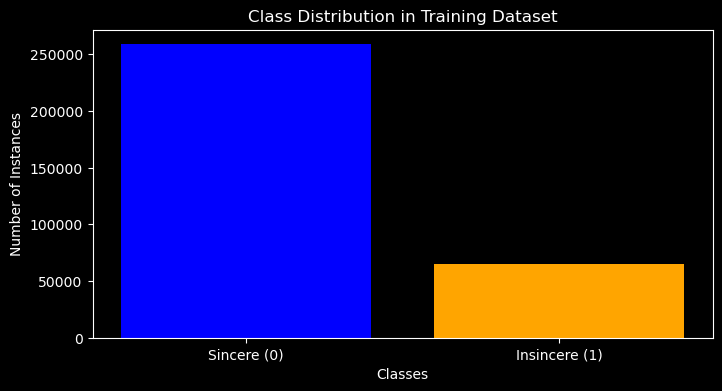

In [9]:
# Visualizing the class distribution in the training dataset
plt.figure(figsize=(8, 4))
plt.bar(
    class_distribution_train.index,
    class_distribution_train.values,
    color=["blue", "orange"],
)
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution in Training Dataset")
# set the x-axis ticks to be the class labels
plt.xticks([0, 1], ["Sincere (0)", "Insincere (1)"])  # 0 = sincere, 1 = insincere
plt.show()

The class distribution in the training dataset is visibly imbalanced, with a significantly higher number of sincere questions compared to insincere ones. This imbalance can lead to a biased model that tends toward predicting the majority class.

### Addressing Class Imbalance (ideas)

To address this imbalance and ensure our model learns to effectively distinguish between both classes, we can consider the following strategies:

1. **Resampling the Dataset**: Either by oversampling the minority class (insincere questions) or undersampling the majority class (sincere questions) to achieve a more balanced distribution.

2. **Weighted Loss Function**: During model training, we can use a weighted loss function to give more importance to the minority class.

3. **Data Augmentation**: Generate new samples for the minority class by using techniques like synonym replacement, back translation, or paraphrasing.

4. **Use of F1 Score for Model Evaluation**: Since it provides a balance between precision and recall, the F1 score is a more suitable metric than accuracy for imbalanced datasets.

### Text Data Analysis

Text data requires special attention. Here we will:

- Analyze the length of the questions (number of words/characters).
- Explore the most frequent words and terms in the dataset.
- Look at the distribution of question lengths.
- Analyze correlations between words count and class.


In [10]:
# Calculate question length in terms of words
train_df["word_count"] = train_df["question_text"].apply(lambda x: len(x.split()))

# Calculate question length in terms of characters
train_df["char_count"] = train_df["question_text"].apply(len)

# Descriptive statistics for word count
word_count_desc = train_df["word_count"].describe()
print("Word Count Descriptive Statistics:")
print(word_count_desc)

# Descriptive statistics for character count
char_count_desc = train_df["char_count"].describe()
print("\nCharacter Count Descriptive Statistics:")
print(char_count_desc)

Word Count Descriptive Statistics:
count    323240.000000
mean         13.443228
std           7.628281
min           1.000000
25%           8.000000
50%          11.000000
75%          16.000000
max          64.000000
Name: word_count, dtype: float64

Character Count Descriptive Statistics:
count    323240.000000
mean         74.605027
std          42.679392
min           1.000000
25%          45.000000
50%          62.000000
75%          91.000000
max        1017.000000
Name: char_count, dtype: float64


> The average length of questions is 74 words, this gives us a rough idea of the maximum sequence length we can use for our models.

In [11]:
# Tokenize the questions and count the frequency of words
all_words = list(chain.from_iterable(train_df["question_text"].str.split()))

# Count the words using Counter
word_freq = Counter(all_words)

# Display the most common words
most_common_words = word_freq.most_common(20)
print("\nMost Common Words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")


Most Common Words:
the: 168155
to: 106024
a: 100236
What: 92077
in: 88291
of: 84355
is: 80899
I: 71128
and: 69754
How: 59514
are: 55878
do: 54067
Why: 49284
for: 48026
you: 44299
it: 31480
that: 31247
can: 28514
Is: 27859
with: 24902


> As we can see the most common words are stop words, which are not very useful for our task. We will remove them during the preprocessing step. 

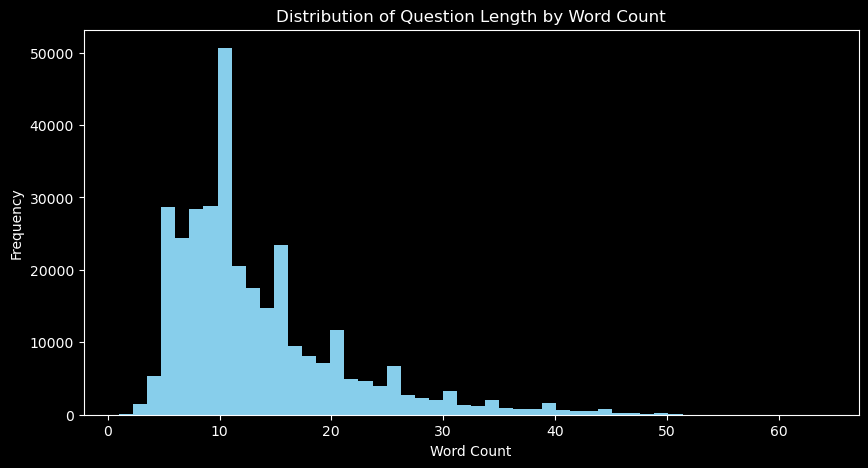

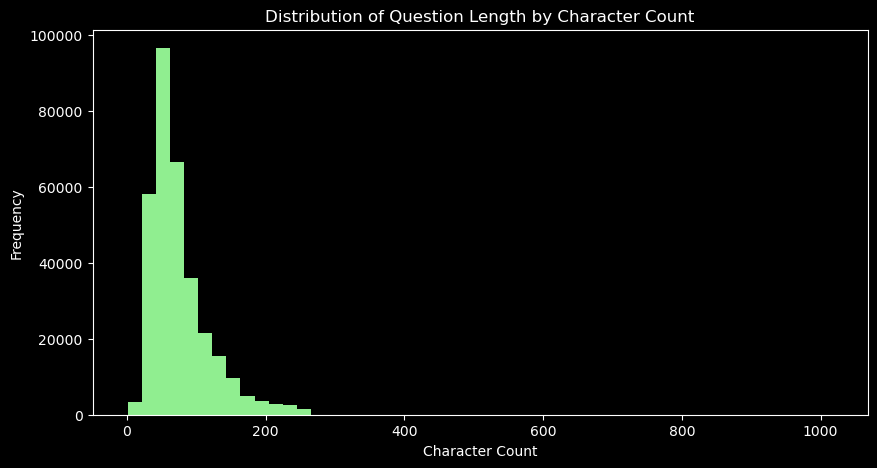

In [12]:
# Plotting the distribution of question lengths by word count
plt.figure(figsize=(10, 5))
plt.hist(train_df["word_count"], bins=50, color="skyblue")
plt.title("Distribution of Question Length by Word Count")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Plotting the distribution of question lengths by character count
plt.figure(figsize=(10, 5))
plt.hist(train_df["char_count"], bins=50, color="lightgreen")
plt.title("Distribution of Question Length by Character Count")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()

In [13]:
correlation = train_df[["word_count", "target"]].corr()

# Display the correlation matrix
print("Correlation between word count and target:")
print(correlation)

Correlation between word count and target:
            word_count    target
word_count    1.000000  0.250098
target        0.250098  1.000000


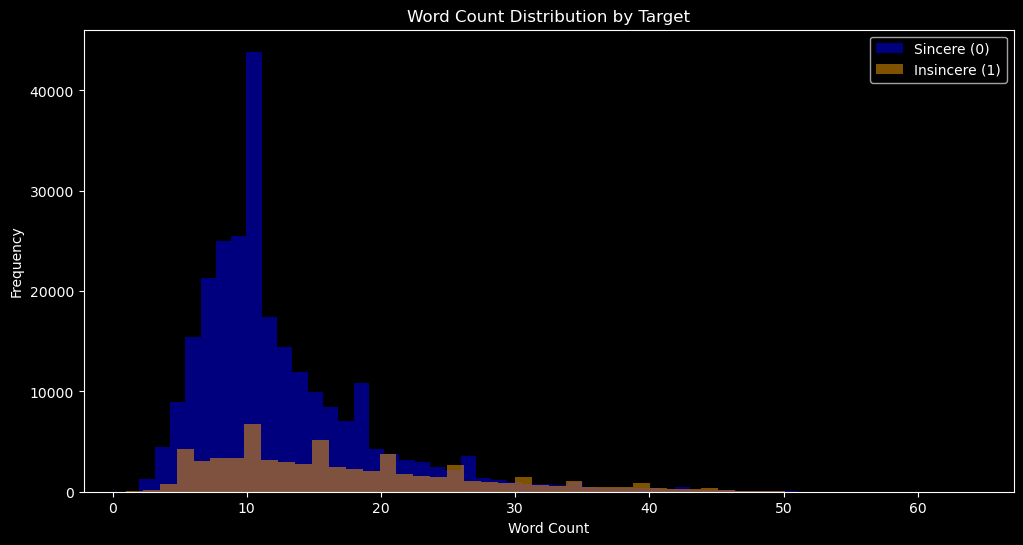

In [14]:
# Filter the DataFrame for sincere and insincere questions
sincere_questions = train_df[train_df["target"] == 0]["word_count"]
insincere_questions = train_df[train_df["target"] == 1]["word_count"]

# Plotting the distribution of word counts by class
plt.figure(figsize=(12, 6))

# Plot sincere questions distribution
plt.hist(sincere_questions, bins=50, alpha=0.5, label="Sincere (0)", color="blue")

# Plot insincere questions distribution
plt.hist(insincere_questions, bins=50, alpha=0.5, label="Insincere (1)", color="orange")

plt.title("Word Count Distribution by Target")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

plt.show()

In [15]:
# Descriptive statistics of word count for each target class
word_count_by_target = train_df.groupby("target")["word_count"].describe()

print("Descriptive Statistics of Word Count by Target Class:")
print(word_count_by_target)

Descriptive Statistics of Word Count by Target Class:
           count       mean       std  min   25%   50%   75%   max
target                                                            
0       258592.0  12.489319  6.730526  2.0   8.0  11.0  15.0  59.0
1        64648.0  17.258863  9.568479  1.0  10.0  15.0  23.0  64.0


The histogram of word counts separated by target classes indicates a notable difference in the distribution of word lengths between sincere and insincere questions. Specifically, insincere questions tend to have a slightly higher word count on average, as evidenced by the rightward shift in their distribution compared to sincere questions.

The correlation coefficient between word count and the target is ~`0.25`, suggesting a mild positive relationship. In the context of our dataset, this means that as the number of words in a question increases, the likelihood of the question being insincere (target=1) also increases, albeit not strongly.

> While word count alone is not a definitive predictor, it provides a supplementary cue that, when combined with other textual features, could enhance the model's performance.

## Preprocessing Requirements

The preprocessing of text data is a critical step in ensuring that our deep learning model receives high-quality input data that reflects the true nature of the language patterns we wish to learn. Based on our preliminary data exploration, we've identified several preprocessing steps that will help improve the performance of our model.

Based on our findings, we will determine:

- The need for text normalization steps such as lowercasing, removing special characters, etc.
- Whether stopwords need to be removed or kept.
- The necessity of stemming or lemmatization.

### Text Normalization

Text normalization is the process of converting text into a more uniform format that allows models to learn more effectively. Based on our dataset, the following normalization steps are recommended:

- **Lowercasing**: Convert all text to lowercase to ensure that the model treats words like "The" and "the" as the same word, reducing the vocabulary size and improving the model's ability to learn patterns.
- **Removing Special Characters**: Non-alphanumeric characters and punctuation can often be noise in text data. However, in certain NLP tasks, punctuation can convey meaningful signals (e.g., question marks indicating questions). We'll need to carefully evaluate which characters to remove.
- **Handling Contractions**: In English, contractions such as "don't" or "can't" are common. We should decide whether to expand these to their full forms ("do not", "cannot") to make them more explicit for the model.


In [16]:
def normalize_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters (anything that is not a letter or number)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

    # Replace multiple whitespaces with a single space
    text = re.sub(r"\s+", " ", text).strip()

    return text


# Apply the normalization function to each question in the dataset
train_df["normalized_text"] = train_df["question_text"].apply(normalize_text)
test_df["normalized_text"] = test_df["question_text"].apply(normalize_text)

### Stopwords

Stopwords are commonly used words that carry little semantic meaning and are often removed from the text. However, the removal of stopwords can sometimes eliminate important context in certain types of analysis. In our case we decided to remove them, since they are not very useful for our task.


In [17]:
# Load the set of English stopwords
stop_words = set(stopwords.words("english"))


def remove_stopwords(text):
    # Tokenize the text into words
    words = word_tokenize(text)
    # Remove the stopwords
    filtered_words = [word for word in words if word not in stop_words]
    # Rejoin the filtered words back into a string
    filtered_text = " ".join(filtered_words)
    return filtered_text


# Apply the remove_stopwords function to each question in the normalized text column
train_df["text_without_stopwords"] = train_df["normalized_text"].apply(remove_stopwords)
test_df["text_without_stopwords"] = test_df["normalized_text"].apply(remove_stopwords)

### Stemming and Lemmatization

Both stemming and lemmatization are techniques used to reduce words to their root form. Lemmatization considers the context and converts the word to its meaningful base form, whereas stemming simply removes the ends of words.

- **Stemming**: This might be too aggressive for our task, as it can sometimes produce stems that are not actual words. It could potentially obscure the meaning of verbs when tense or aspect is important.
- **Lemmatization**: This is a more sophisticated approach that might be more appropriate for our task. It reduces words to their lemma, or dictionary form, and preserves semantic meaning.


In [18]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV,
    }

    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize_text(text):
    # Tokenize the text into words
    words = word_tokenize(text)
    # Lemmatize each word with its correct part-of-speech tag
    lemmatized_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words]
    # Rejoin the lemmatized words back into a single string
    lemmatized_text = " ".join(lemmatized_words)
    return lemmatized_text


# Apply the lemmatize_text function to each question in the text without stopwords column
train_df["lemmatized_text"] = train_df["text_without_stopwords"].apply(lemmatize_text)
test_df["lemmatized_text"] = test_df["text_without_stopwords"].apply(lemmatize_text)

In [19]:
# Select two examples from the dataset
example_questions = train_df.sample(2, random_state=SEED)

# Display the text evolution for each example
for _, row in example_questions.iterrows():
    print("Original Question:")
    print(row["question_text"])
    print("\nNormalized Text:")
    print(row["normalized_text"])
    print("\nWithout Stopwords:")
    print(row["text_without_stopwords"])
    print("\nLemmatized Text:")
    print(row["lemmatized_text"])
    print("\n" + "-" * 80 + "\n")

Original Question:
How can I change from Android to iOS without rebooting my phone?

Normalized Text:
how can i change from android to ios without rebooting my phone

Without Stopwords:
change android ios without rebooting phone

Lemmatized Text:
change android io without reboot phone

--------------------------------------------------------------------------------

Original Question:
What do people think of India?

Normalized Text:
what do people think of india

Without Stopwords:
people think india

Lemmatized Text:
people think india

--------------------------------------------------------------------------------



![kevin](assets/kevin.gif)

## Vocabulary Creation + Word Embeddings

We are going to create a vocabulary dump for the problem, so that we can represent each word with a unique integer. This will allow us to represent a review as a list of ints (which the model will then map to word embeddings).

One thing to keep in mind is that we will want to add padding to our inputs (so that all the reviews have the same length), for this we will use 0, so the words in our vocabulary must start at 1.

In [20]:
import operator


# OOV = Out of Vocabulary
def make_vocab(all_texts, max_vocab_size, oov_token="<OOV>"):
    # Count the number of occurrences of each word
    counts = Counter(chain(*all_texts.str.split()))
    # Create vocab containing max_vocab_size tokens
    # Add the out of vocabulary at the end
    sorted_counts = sorted(counts.items(), key=operator.itemgetter(1), reverse=True)[
        :max_vocab_size
    ]
    vocab = [token for token, count in sorted_counts] + [oov_token]
    # Map from word to int index in vocab
    vocab_to_int = {word: (ii + 1) for ii, word in enumerate(vocab)}
    return vocab_to_int

In [21]:
vocab_mapping = make_vocab(train_df["lemmatized_text"], max_vocab_size=100_000)

Now let's implement a function that transforms a string with the review into a list of integers with the position of each of our words in the vocabulary. If a word is not in the vocabulary we use the index for`<OOV>`.

In [22]:
def get_question_features(text, word_to_idx):
    # Convert text to indices
    indices = [word_to_idx.get(word, word_to_idx["<OOV>"]) for word in text.split()]
    return indices

The next thing is to implement padding of the sentences, although the models are able to work with sequences of any length we want the training and inference time to be controlled and not depend on the length of the inputs. As a small optimization we are going to do **left padding**, that is, add 0s to the left of a sequence until we reach `max_sequence_length` elements.

Adding leading zeros helps the models to learn from the data since the valuable information appears at the end of the sequence and it does not have to remember 3 words after having seen 100 zeros.

In [23]:
def pad_features(review_ints, sequence_length):
    if len(review_ints) > sequence_length:
        return review_ints[:sequence_length]
    else:
        return [0] * (sequence_length - len(review_ints)) + review_ints

In [24]:
def get_question_representation(review_text, word_to_idx, max_sequence_length):
    return pad_features(
        get_question_features(review_text, word_to_idx), max_sequence_length
    )

### Text Vectorization

Now that we have our vocabulary, we can vectorize our text data. We will use the `get_question_representation` function to vectorize the text into integer token IDs. We will also use the `pad_sequences` function to ensure that all our sequences are padded to the same length.

In [25]:
MAX_SEQUENCE_LENGTH = 150

train_vectors = train_df["lemmatized_text"].apply(
    lambda x: get_question_representation(x, vocab_mapping, MAX_SEQUENCE_LENGTH)
)
test_vectors = test_df["lemmatized_text"].apply(
    lambda x: get_question_representation(x, vocab_mapping, MAX_SEQUENCE_LENGTH)
)

train_vectors = np.array([vec for vec in train_vectors])
test_vectors = np.array([vec for vec in test_vectors])

Before proceeding, we will split our dataset into training and validation sets. We will use 80% of the data for training and 20% for validation.

In [26]:
# split train and validation sets
train_vectors, val_vectors, train_labels, val_labels = train_test_split(
    train_vectors, train_df["target"], test_size=0.2, random_state=SEED
)

## Training

### Auxiliary Functions

In [27]:
import copy

def train_epoch(training_model, loader, criterion, optim):
    training_model.train()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    for data, labels in loader:
        all_labels.extend(labels.numpy())

        optim.zero_grad()

        predictions = training_model(data.to(DEVICE))
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        loss = criterion(predictions, labels.to(DEVICE))

        loss.backward()
        optim.step()

        epoch_loss += loss.item()

    f1 = f1_score(all_labels, all_predictions, average="binary")
    return epoch_loss / len(loader), f1 * 100


def validation_epoch(val_model, loader, criterion):
    val_model.eval()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data, labels in loader:
            all_labels.extend(labels.numpy())

            predictions = val_model(data.to(DEVICE))
            all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

            loss = criterion(predictions, labels.to(DEVICE))

            epoch_loss += loss.item()

    f1 = f1_score(all_labels, all_predictions, average="binary")
    return epoch_loss / len(loader), f1 * 100


def train_model(
    model, train_loader, test_loader, criterion, optim, number_epochs, patience=5
):
    train_history = []
    test_history = []

    # Variables for Early Stopping
    best_loss = float("inf")
    epochs_no_improve = 0
    best_model = copy.deepcopy(model)

    for epoch in range(number_epochs):
        start_time = time.time()

        train_loss, train_f1 = train_epoch(model, train_loader, criterion, optim)
        train_history.append(train_loss)
        print(
            "Training epoch {} | Loss {:.6f} | F1 Score {:.2f}% | Time {:.2f} seconds".format(
                epoch + 1, train_loss, train_f1, time.time() - start_time
            )
        )

        start_time = time.time()
        test_loss, test_f1 = validation_epoch(model, test_loader, criterion)
        test_history.append(test_loss)
        print(
            "Validation epoch {} | Loss {:.6f} | F1 Score {:.2f}% | Time {:.2f} seconds".format(
                epoch + 1, test_loss, test_f1, time.time() - start_time
            )
        )

        # Early Stopping Check
        if test_loss < best_loss:
            best_loss = test_loss
            epochs_no_improve = 0
            best_model = copy.deepcopy(model)
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping triggered. Training stopped.")
            break

    return train_history, test_history, best_model

### Model Definition

### Model Architecture

The `SincereRNN` model is structured as follows:

1. **Embedding Layer**: 
   - The first layer of the model is an embedding layer. 
   - It transforms the input vocabulary indices into dense vectors of a specified size (`embedding_dim`).
   - The `vocab_size` parameter defines the size of the input vocabulary.

2. **Recurrent Neural Network (RNN)**: 
   - The embedding output is then passed through a simple RNN layer. 
   - This RNN has `hidden_dim` units and is designed to process the data sequentially, capturing the temporal dependencies.
   - The `batch_first=True` parameter indicates that the input tensors are expected to have a batch size as the first dimension.

3. **Fully Connected and Dropout Layers**:
   - After the RNN layer, the output passes through a series of fully connected (linear) layers.
   - The first linear layer transforms the RNN output to a size of 512 units.
   - This is followed by a ReLU activation function and a dropout layer with a dropout rate of 0.5 for regularization.
   - A second fully connected layer reduces the dimension to 256 units, followed again by ReLU and dropout for added non-linearity and regularization.
   - The final fully connected layer (`fc3`) maps the output to 2 units, suitable for binary classification tasks.

In [28]:
class SincereRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(SincereRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        # 1. Embedding
        x = self.embedding(x)

        # 2. RNN
        x, _ = self.rnn(x)

        # 3. Linear
        x = self.fc(x[:, -1, :])
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)

        return x

### Training Loop

In [29]:
# we are going to use weighted loss function since the dataset is imbalanced

class_counts = train_df["target"].value_counts().to_list()
total_count = sum(class_counts)
class_weights = [total_count / class_counts[0], total_count / class_counts[1]]

# Convert class weights to a tensor
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

# Define the weighted loss function
loss_function = nn.CrossEntropyLoss(weight=weights_tensor).to(DEVICE)

In [30]:
# creating dataloaders

BATCH_SIZE = 32

train_targets = torch.Tensor(train_labels.to_numpy()).long()
train_dataset = TensorDataset(torch.LongTensor(train_vectors), train_targets)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=8
)

val_targets = torch.Tensor(val_labels.to_numpy()).long()
val_dataset = TensorDataset(torch.LongTensor(val_vectors), val_targets)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=8
)

test_targets = torch.Tensor(test_df["target"].to_numpy()).long()
test_dataset = TensorDataset(torch.LongTensor(test_vectors), test_targets)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=8
)

In [31]:
# training the model
EMBEDDING_DIM = math.ceil(len(vocab_mapping) ** 0.5)
HIDDEN_DIM = 64
LR = 0.0001
EPOCHS = 50

model = SincereRNN(len(vocab_mapping) + 1, EMBEDDING_DIM, HIDDEN_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_history, test_history, best_model = train_model(
    model, train_dataloader, val_dataloader, loss_function, optimizer, EPOCHS
)

Training epoch 1 | Loss 0.481536 | F1 Score 57.49% | Time 34.94 seconds
Validation epoch 1 | Loss 0.371556 | F1 Score 69.43% | Time 1.21 seconds
Training epoch 2 | Loss 0.343612 | F1 Score 71.43% | Time 34.91 seconds
Validation epoch 2 | Loss 0.337840 | F1 Score 72.51% | Time 1.17 seconds
Training epoch 3 | Loss 0.303361 | F1 Score 74.29% | Time 34.23 seconds
Validation epoch 3 | Loss 0.328940 | F1 Score 73.78% | Time 1.16 seconds
Training epoch 4 | Loss 0.277676 | F1 Score 75.95% | Time 34.55 seconds
Validation epoch 4 | Loss 0.330739 | F1 Score 74.50% | Time 1.11 seconds
Training epoch 5 | Loss 0.257275 | F1 Score 77.41% | Time 34.42 seconds
Validation epoch 5 | Loss 0.344418 | F1 Score 74.90% | Time 1.10 seconds
Training epoch 6 | Loss 0.240584 | F1 Score 78.70% | Time 34.68 seconds
Validation epoch 6 | Loss 0.351683 | F1 Score 74.91% | Time 1.14 seconds
Training epoch 7 | Loss 0.225870 | F1 Score 79.77% | Time 34.50 seconds
Validation epoch 7 | Loss 0.364839 | F1 Score 75.13% | Tim

### Plotting the Training Curves

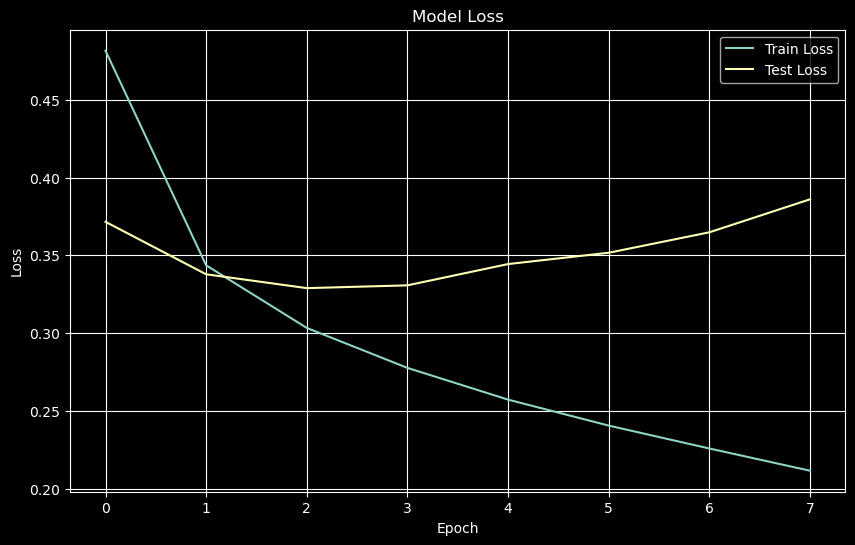

In [32]:
def plot_history(
    train_history,
    test_history,
    title="Model Loss",
    train_label="Train Loss",
    test_label="Test Loss",
):
    plt.figure(figsize=(10, 6))
    plt.plot(train_history, label=train_label)
    plt.plot(test_history, label=test_label)
    plt.title(title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_history(train_history, test_history)

Training Loss: The training loss is consistently decreasing, which typically suggests that the model is learning and improving its performance on the training dataset over epochs.

Test Loss: The test loss decreases initially but starts to increase after epoch 3. This could be an indication that the model is beginning to overfit the training data.

## Evaluation

Now that we have trained our model, we can evaluate its performance on the test dataset. We will use the `evaluate_model` function to compute the loss and metrics on the test dataset (this data was not used during training or validation).

In [33]:
def evaluate_model(model, test_dataloader, criterion):
    model.eval()  # Set the model to evaluation mode

    test_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_dataloader:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_test_loss = test_loss / len(test_dataloader)
    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    # Compute additional metrics
    f1 = f1_score(all_targets, all_predictions, average="binary")
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    conf_matrix = confusion_matrix(all_targets, all_predictions)

    return avg_test_loss, f1, precision, recall, conf_matrix


test_loss, f1, precision, recall, conf_matrix = evaluate_model(
    best_model, test_dataloader, loss_function
)
print(
    f"Test Loss: {test_loss:.4f}, F1 Score: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}"
)
print("Confusion Matrix:\n", conf_matrix)

/home/k/anaconda3/envs/question-classifier-nlp/lib/python3.11/site-packages/torch/nn/modules/rnn.py:555: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /opt/conda/conda-bld/pytorch_1695454903670/work/aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,


Test Loss: 0.3321, F1 Score: 0.73, Precision: 0.64, Recall: 0.86
Confusion Matrix:
 [[56853  7795]
 [ 2248 13914]]


We have similar results to the validation set, which is good news. We can see that the model is not overfitting the training data.